# Jupyter notebooks - hands on R

In [1]:
#setwd("/home/rok/dl/ektimo/")
require(randomForest)
require(dplyr)
require(magrittr)
require(ggplot2)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



## Load data and check basic properties

Variable names are:
- age (numeric)
- default: has credit in default? (categorical: 'no','yes','unknown')
- balance: account balance
- housing: has housing loan? (categorical: 'no','yes','unknown')
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day: last contact day of the month
- duration: last contact duration, in seconds (numeric). **Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.**
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [2]:
#bank <- read.csv(file="bank-full.csv",header=TRUE,sep=";", stringsAsFactors=FALSE) %>% as.tbl
bank <- read.csv(file="BankData/bank-full.csv",header=TRUE,sep=";") %>% as.tbl
bank %<>% mutate(id=1:n(),outcome=ifelse(y=="no", 0, 1)) %>%
    select(y,age,default,balance,housing,contact,month,day,campaign,pdays,poutcome,id,outcome)

#how many with "yes" response      
bank %>% group_by(y) %>% summarise(n())


,y,n()
1,no,39922
2,yes,5289


## Split the dataset in two sets - train and test

In [10]:
trainingData <- bank %>% sample_frac(0.01)
head(trainingData)
str(trainingData)
contactModel <- nrow(trainingData)
responseTrain <- sum(trainingData$y == "yes")

,y,age,default,balance,housing,contact,month,day,campaign,pdays,poutcome,id,outcome
1,no,34,no,1259,yes,cellular,may,6,2,169,failure,35078,0
2,no,27,no,1991,no,cellular,sep,7,1,-1,unknown,41472,0
3,no,26,no,2182,yes,cellular,may,12,1,292,other,36524,0
4,no,56,no,191,no,cellular,jul,23,3,-1,unknown,16393,0
5,no,31,no,5,yes,cellular,jul,16,7,-1,unknown,14940,0
6,no,37,no,660,yes,cellular,feb,5,4,-1,unknown,30465,0


Classes ‘tbl_df’ and 'data.frame':	452 obs. of  13 variables:
 $ y       : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 2 1 2 1 ...
 $ age     : int  34 27 26 56 31 37 40 46 54 47 ...
 $ default : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance : int  1259 1991 2182 191 5 660 1758 1410 0 1544 ...
 $ housing : Factor w/ 2 levels "no","yes": 2 1 2 1 2 2 2 2 1 2 ...
 $ contact : Factor w/ 3 levels "cellular","telephone",..: 1 1 1 1 1 1 3 1 2 1 ...
 $ month   : Factor w/ 12 levels "apr","aug","dec",..: 9 12 9 6 6 4 9 10 1 1 ...
 $ day     : int  6 7 12 23 16 5 16 19 30 6 ...
 $ campaign: int  2 1 1 3 7 4 3 1 3 1 ...
 $ pdays   : int  169 -1 292 -1 -1 -1 -1 189 84 312 ...
 $ poutcome: Factor w/ 4 levels "failure","other",..: 1 4 2 4 4 4 4 1 3 1 ...
 $ id      : int  35078 41472 36524 16393 14940 30465 3830 25899 34161 31639 ...
 $ outcome : num  0 0 0 0 0 0 1 0 1 0 ...


In [11]:
testData <- bank %>% filter(!id %in% trainingData$id)
head(testData)

,y,age,default,balance,housing,contact,month,day,campaign,pdays,poutcome,id,outcome
1,no,58,no,2143,yes,unknown,may,5,1,-1,unknown,1,0
2,no,44,no,29,yes,unknown,may,5,1,-1,unknown,2,0
3,no,33,no,2,yes,unknown,may,5,1,-1,unknown,3,0
4,no,47,no,1506,yes,unknown,may,5,1,-1,unknown,4,0
5,no,33,no,1,no,unknown,may,5,1,-1,unknown,5,0
6,no,35,no,231,yes,unknown,may,5,1,-1,unknown,6,0


## Train random forest model

In [12]:
firstRF <- randomForest(y~age+default+balance+housing+contact+month+day+campaign+pdays+poutcome,data=trainingData,importance=TRUE)
testData %<>% mutate(predicted=predict(firstRF,.,type="prob")[,2]) %>%
	mutate(outcome=ifelse(y=="no", 0, 1))
firstRF


Call:
 randomForest(formula = y ~ age + default + balance + housing +      contact + month + day + campaign + pdays + poutcome, data = trainingData,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.84%
Confusion matrix:
     no yes class.error
no  388   3 0.007672634
yes  46  15 0.754098361

## Even though the results are not very accurate, we can try to sort predictions and compare it to random and balance order

In [15]:
randomContact <- bank %>% sample_frac(0.99) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="random", orderIndex=1:n())
balanceContact <- bank %>% sample_frac(0.99) %>% arrange(desc(balance)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="balance", orderIndex=1:n())
predictedContact <- testData %>% arrange(desc(predicted)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="predicted", orderIndex=1:n())

Pokličemo nekaj ljudi za model, potem postavimo model, nato pokličemo ostale po verjetnosti sklenitve depozita. Slika prikazuje kako bi morali iti.

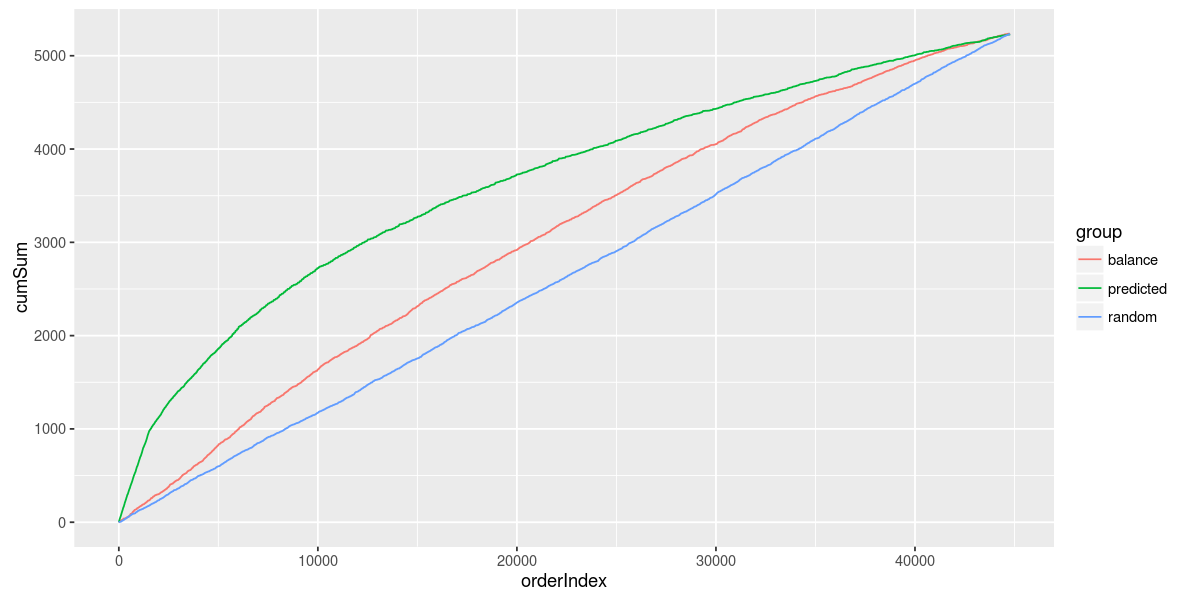

In [16]:
options(repr.plot.width=10, repr.plot.height=5)
randomContact %>% bind_rows(predictedContact) %>% bind_rows(balanceContact) %>%
	ggplot(data=., aes(orderIndex,cumSum)) + geom_line(aes(colour=group))

Če bi jih poklicali skupno samo 1000, bi imeli po modelu sklenjenih 425 depozitov.

In [19]:
noContact <- 1000
result <- randomContact %>% slice(noContact) %>% summarize(type="random", contacted=orderIndex, responded=cumSum) %>% 
bind_rows(balanceContact %>% slice(noContact) %>% summarize(type="balance",contacted=orderIndex, responded=cumSum)) %>%
bind_rows(predictedContact %>% slice(noContact-contactModel) %>% summarize(type="model",contacted=orderIndex+contactModel, responded=cumSum+responseTrain))

In [20]:
result %>% mutate(improvement=responded/responded[1])

,type,contacted,responded,improvement
1,random,1000,124,1
2,balance,1000,159,1.282258
3,model,1000,425,3.427419
